# ComputeFramework

**One big idea: break up large data into pieces, run computations on the pieces without filling up memory**

Low-level view:

A framework for
  - out-of-core
  - parallel
  
  
High-level:

- Array library

## Out-of-core
Out-of-core computation means working with data which does not fit in the RAM. Let's find out how much RAM we have left. `Sys.free_memory()` can tell you this.

In [1]:
_dummy = rand(ceil(Int, 10^9));

In [2]:
Sys.free_memory() / 10^9

5.38324992

In [3]:
X = rand(10^9)

LoadError: LoadError: OutOfMemoryError()
while loading In[3], in expression starting on line 1

In [4]:
LENGTH = ceil(Int, 10^9)

1000000000

In [5]:
io = open("/scratch/mybigarray", "w+")
X = Mmap.mmap(io, Vector{Float64}, (LENGTH,))
close(io)

In [6]:
@time rand!(X)

 36.559375 seconds (346 allocations: 22.779 KB)


1000000000-element Array{Float64,1}:
 0.359553 
 0.0328328
 0.140618 
 0.334557 
 0.879895 
 0.654266 
 0.0764878
 0.744542 
 0.40822  
 0.680392 
 0.456317 
 0.641942 
 0.683228 
 ⋮        
 0.800328 
 0.122069 
 0.776288 
 0.547517 
 0.385899 
 0.928934 
 0.836305 
 0.873217 
 0.265356 
 0.661576 
 0.0882204
 0.25225  

Let's try to do something with it.

In [7]:
@time sum(X)

 19.456628 seconds (24.76 k allocations: 1.053 MB)


4.999966971123016e8

But `mmap` quickly stops working...

In [8]:
sum(sin(X).^2 + cos(X).^2)

LoadError: LoadError: OutOfMemoryError()
while loading In[8], in expression starting on line 1

### Creating a big array with ComputeFramework

In [9]:
#Pkg.clone("git://github.com/shashi/ComputeFramework.jl.git")
using ComputeFramework

In [57]:
x = rand(BlockPartition(ceil(Int, LENGTH/10)), LENGTH)
@time X = compute(save(x, "/scratch/X"))

 28.762864 seconds (35.31 k allocations: 7.452 GB, 1.33% gc time)


ComputeFramework.Computed(1000000000 Array{Float64,1} in 10 parts)

In [58]:
X = load(Context(), "/scratch/X")

ComputeFramework.Computed(1000000000 Array{Float64,1} in 10 parts)

In [ ]:
@time d,x= debug_compute(sum(sin(X).^2 + cos(X).^2))

In [18]:
t = ComputeFramework.stage(Context(), sum(sin(X).^2 + cos(X).^2))

*646*

In [71]:
import ComputeFramework: Thunk

function node_label(io, t::ComputeFramework.Thunk)
    if isgeneric(t.f)
        println(io, "$(t.id) [label=\"$(t.f)\"]")
    else
        println(io, "$(t.id) [label=\"fn\"]")
    end
end

function node_label(io, t)
end

global cnt=0
_part_labels = Dict()
function node_label(io, t::ComputeFramework.Part)
    global cnt += 1
    _part_labels[t]="part_$cnt"
    #println(io, "file-$cnt")
end

function node_id(t::ComputeFramework.Thunk)
    t.id
end

function node_id(t::ComputeFramework.Part)
    _part_labels[t]
end

function draw_dag(io, t)
    !ComputeFramework.istask(t) && return io
    deps = ComputeFramework.dependents(t)
    for k in keys(deps)
        c = node_label(io, k, c)
    end
    for (k, v) in deps
        for dep in v
            println(io, "$(node_id(k)) -> $(node_id(dep))")
        end
    end
end

function dot(t::Thunk)
    io = IOBuffer()
    draw_dag(io, t)
    """digraph {
        graph [layout=dot, rankdir=TB];
        $(takebuf_string(io))
    }"""
end

dot (generic function with 1 method)

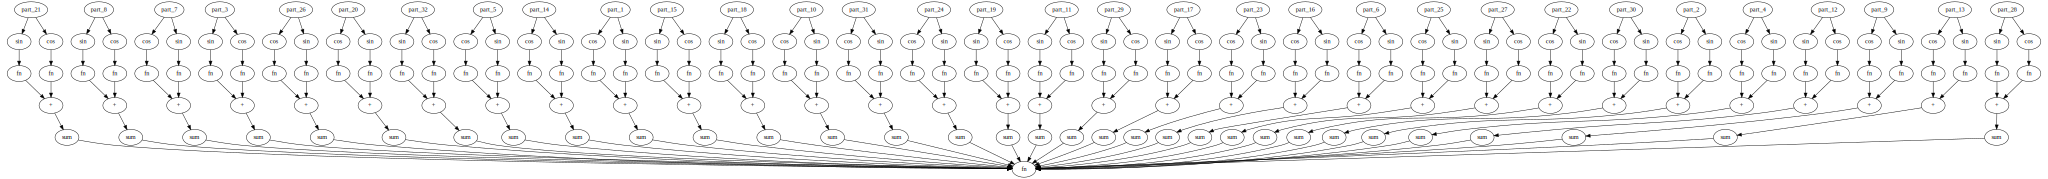

In [72]:
Graph(dot(t))

In [20]:
Pkg.add("GraphViz")

INFO: Cloning cache of BinDeps from git://github.com/JuliaLang/BinDeps.jl.git
INFO: Cloning cache of GraphViz from git://github.com/Keno/GraphViz.jl.git
INFO: Cloning cache of SHA from git://github.com/staticfloat/SHA.jl.git
INFO: Cloning cache of URIParser from git://github.com/JuliaWeb/URIParser.jl.git
INFO: Installing BinDeps v0.3.21
INFO: Installing GraphViz v0.0.4
INFO: Installing SHA v0.1.2
INFO: Installing URIParser v0.1.3
INFO: Building GraphViz
INFO: Recompiling stale cache file /opt/julia_packages/.julia/lib/v0.4/BinDeps.ji for module BinDeps.
INFO: Recompiling stale cache file /opt/julia_packages/.julia/lib/v0.4/URIParser.ji for module URIParser.
INFO: Recompiling stale cache file /opt/julia_packages/.julia/lib/v0.4/SHA.ji for module SHA.
  This is likely because module Compat does not support  precompilation but is imported by a module that does.
  This is likely because module URIParser does not support  precompilation but is imported by a module that does.
  likely near /

In [22]:
using GraphViz